In [21]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
from metrics import print_evaluation_metrics

In [22]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path)
df = df[[date_column, target_column, "New_cases"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [23]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [24]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [25]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2023-12-09 13:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     











chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:42:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































2023-12-09 13:42:04 - orbit - INFO - Sampli


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     












































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:42:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 StatusINFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2023-12-09 13:42:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |██▌       | 00:00 Status























































chain 4 |██








































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:42:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:42:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2023-12-09 13:42:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:42:10 - orbit - INFO - Sampling (P

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
















chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:42:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2023-12-09 13:42:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Samplin


2023-12-09 13:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status



chain 4 |          | 00:00 Status2023-12-09 13:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:42:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chai
































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















2023-12-09 13:42:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status




























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-09 13:42:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


























2023-12-09 13:42:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     












































2023-12-09 13:42:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status









chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



chain 2 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2023-12-09 13:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:00 Sampling completed                     

chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status










chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

























2023-12-09 13:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     





chain 4 |██████████| 00:00 Sampling completed                     







chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:00 Status

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██▌       | 00:00 Status












chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2023-12-09 13:42:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



































2023-12-09 13:42:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     










2023-12-09 13:42:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-12-09 13:42:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:01 Sampling completed                     INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |          | 00:00 Status




















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2023-12-09 13:42:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

















































































2023-12-09 13:42:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     







































2023-12-09 13:42:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |          | 00:00 Status


















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:42:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   






2023-12-09 13:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status













2023-12-09 13:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



























2023-12-09 13:42:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     






2023-12-09 13:42:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status














chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:42:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:42:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling 

































2023-12-09 13:42:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status



















chain 1 |██▌       | 00:00 Status






































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)A2023-12-09 13:42:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 4 |██▌       | 00:00 Status

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



































2023-12-09 13:42:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     



chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:42:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
















2023-12-09 13:42:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-09 13:42:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






















chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:42:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-12-09 13:42:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































2023-12-09 13:42:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     








chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:42:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:42:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




















2023-12-09 13:42:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status






2023-12-09 13:42:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                   

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















2023-12-09 13:42:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     











chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















2023-12-09 13:42:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:42:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |██▌       | 00:00 Status2023-12-09 13:42:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)














































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














2023-12-09 13:42:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























chain 1 |██▌       | 00:00 Status























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:42:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     














chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:42:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:42:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




2023-12-09 13:42:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and 

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 2 |          | 00:00 Status



































































































chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |██████████| 00:01 Sampling completed                     

chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




2023-12-09 13:42:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     












2023-12-09 13:42:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)










2023-12-09 13:42:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2023-12-09 13:42:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 3 |██▌       | 00:00 Status













chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     




































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:42:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:42:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:42:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |



























2023-12-09 13:42:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Status






































chain 1 |██▌       | 00:00 Status
































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-09 13:42:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



2023-12-09 13:42:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2023-12-09 13:42:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and sa









2023-12-09 13:42:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status













































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     











2023-12-09 13:42:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     


















chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








































2023-12-09 13:42:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |██▌       | 00:00 Status





chain 4 |██▌       | 00:00 Status2023-12-09 13:42:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























chain 4 |██▌       | 00:00 Status2023-12-09 13:42:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     











2023-12-09 13:42:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██████████| 00:00 Sampling completed                     
chain 1 |██▌       | 00:00 Status
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-12-09 13:42:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:42:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































2023-12-09 13:42:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |████




















2023-12-09 13:42:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |          | 00:00 Statusion: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:42:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





2023-12-09 13:42:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status






















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









2023-12-09 13:42:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:42:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |          | 00:00 Status
chain 2 |██▌       | 00:00 Status
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-09 13:42:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2023-12-09 13:42:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































2023-12-09 13:42:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     






















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     


2023-12-09 13:42:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


2023-12-09 13:42:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






2023-12-09 13:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status


2023-12-09 13:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












2023-12-09 13:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Status























chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                   



chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




2023-12-09 13:43:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:01 Sampling completed                     2023-12-09 13:43:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     








chain 3 |██▌       | 00:00 Status

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status
















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:43:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




















































































2023-12-09 13:43:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and sa




chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status
















chain 3 |██▌       | 00:00 Status































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     









chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     2023-12-09 13:43:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status









chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




























2023-12-09 13:43:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   







chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     







chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)







































2023-12-09 13:43:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |          | 00:00 Status





























chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-09 13:43:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2023-12-09 13:43:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























2023-12-09 13:43:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |███████
















2023-12-09 13:43:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:43:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     







2023-12-09 13:43:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status

















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:43:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































2023-12-09 13:43:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |












chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     







chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:43:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-12-09 13:43:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██▌       | 00:00 Status























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:43:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) w











































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
























































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:43:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2023-12-09 13:43:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed   







2023-12-09 13:43:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status
































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     










chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:43:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     2023-12-09 13:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 4 |██████████| 00:01 Sampling completed                     


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2023-12-09 13:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████














































2023-12-09 13:43:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 3 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:00 Status





































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


2023-12-09 13:43:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2023-12-09 13:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




























































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temp

chain 1 |          | 00:00 Status



































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:43:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     






chain 1 |██▌       | 00:00 Status

chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     






























2023-12-09 13:43:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:43:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:43:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































2023-12-09 13:43:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |██████████| 00:01 Sampling

















































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     













chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:43:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2023-12-09 13:43:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:43:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████










































2023-12-09 13:43:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |          | 00:00 Status


























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   




chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     





chain 4 |██████████| 00:00 Sampling completed                   g)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:43:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



2023-12-09 13:43:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling comp


2023-12-09 13:43:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status

















2023-12-09 13:43:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





























































2023-12-09 13:43:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (W













































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2023-12-09 13:43:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















2023-12-09 13:43:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |███████▌  | 0






































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-09 13:43:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██▌       | 00:00 Status






















































chain 1 |█████     | 00:0



























chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     







chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     














chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



2023-12-09 13:43:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:43:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-09 13:43:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2023-12-09 13:43:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and sampl
















chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |          | 00:00 Status








chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:43:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:43:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)






















































2023-12-09 13:43:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores
















































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     







chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                   
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2023-12-09 13:43:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





2023-12-09 13:43:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-12-09 13:43:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-12-09 13:43:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (


chain 1 |          | 00:00 Status

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██▌       | 00:00 Status










































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













2023-12-09 13:43:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Samp


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     
























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     













chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:43:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2023-12-09 13:43:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2023-12-09 13:43:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


































chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   









































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2023-12-09 13:43:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:43:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 3 |██▌       | 00:00 StatusINFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















2023-12-09 13:43:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and s






























































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                   






















chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

















chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


























2023-12-09 13:43:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     




chain 3 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-09 13:43:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

















2023-12-09 13:43:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed       


2023-12-09 13:43:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status
















































2023-12-09 13:43:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:43:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     
















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-09 13:44:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




































2023-12-09 13:44:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████|








2023-12-09 13:44:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-09 13:44:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Samp














































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-09 13:44:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-09 13:44:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-09 13:44:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-09 13:44:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)






































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     









2023-12-09 13:44:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


2023-12-09 13:44:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































2023-12-09 13:44:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

2023-12-09 13:44:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:16 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampli











chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

























2023-12-09 13:44:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:44:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


















2023-12-09 13:45:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-09 13:45:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-09 13:45:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     















2023-12-09 13:45:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


















2023-12-09 13:45:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     








2023-12-09 13:45:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     


































































2023-12-09 13:45:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






























































2023-12-09 13:45:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










2023-12-09 13:45:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)






















































2023-12-09 13:45:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

2023-12-09 13:45:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:45:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed          






























2023-12-09 13:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status





















































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


















2023-12-09 13:45:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
























2023-12-09 13:45:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)






2023-12-09 13:45:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)












































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)






















2023-12-09 13:45:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     







chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2023-12-09 13:45:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































































2023-12-09 13:45:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed              



























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2023-12-09 13:45:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)





2023-12-09 13:46:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)











































































2023-12-09 13:46:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     










































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:46:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status






































2023-12-09 13:46:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed        










2023-12-09 13:46:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-09 13:46:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















2023-12-09 13:46:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)




























2023-12-09 13:46:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     
















































2023-12-09 13:46:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

















































2023-12-09 13:46:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:46:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)





































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















2023-12-09 13:46:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












2023-12-09 13:46:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:0







chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:46:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

































































































2023-12-09 13:46:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

2023-12-09 13:46:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)































2023-12-09 13:46:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██


































2023-12-09 13:46:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2023-12-09 13:46:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)














2023-12-09 13:46:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)








































2023-12-09 13:46:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











2023-12-09 13:46:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

























2023-12-09 13:46:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


















2023-12-09 13:46:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


























2023-12-09 13:46:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)












































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





























2023-12-09 13:46:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status
































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 13:46:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:46:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)
































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





























2023-12-09 13:47:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     























2023-12-09 13:47:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status









chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

























































2023-12-09 13:47:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     




2023-12-09 13:47:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)







2023-12-09 13:47:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:47:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-09 13:47:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     








2023-12-09 13:47:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-12-09 13:47:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































2023-12-09 13:47:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

























2023-12-09 13:47:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)





























































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling complet


chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:47:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     














chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-09 13:47:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2023-12-09 13:47:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:47:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
2023-12-09 13:47:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     






































































2023-12-09 13:48:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


































2023-12-09 13:48:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

chain 3 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)









2023-12-09 13:48:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2023-12-09 13:48:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████

2023-12-09 13:48:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     















chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:48:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















2023-12-09 13:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



















































2023-12-09 13:48:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


























2023-12-09 13:48:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:48:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




















chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)











2023-12-09 13:48:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)





































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













































2023-12-09 13:48:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
























2023-12-09 13:48:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:48:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)


































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     





















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-12-09 13:48:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



















2023-12-09 13:48:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





















































































2023-12-09 13:48:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:48:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     





















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:48:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








2023-12-09 13:48:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     













2023-12-09 13:49:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)












2023-12-09 13:49:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:49:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)








































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██












chain 3 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 4 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)













































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-09 13:49:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:49:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































2023-12-09 13:49:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |

2023-12-09 13:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




















































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     










































2023-12-09 13:49:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



















































2023-12-09 13:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)


































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     















































2023-12-09 13:49:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























2023-12-09 13:49:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Samp



























chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     














2023-12-09 13:49:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status



















2023-12-09 13:49:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







2023-12-09 13:49:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |███
























































2023-12-09 13:49:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status


























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


































































2023-12-09 13:49:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     








chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-09 13:49:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2023-12-09 13:50:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed  









2023-12-09 13:50:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



















2023-12-09 13:50:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     















2023-12-09 13:50:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed          















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 13:50:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












2023-12-09 13:50:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampl
























2023-12-09 13:50:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     









































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:50:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)








































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:50:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-09 13:50:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)







































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

















chai








































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)













































2023-12-09 13:50:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     












chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





2023-12-09 13:50:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































2023-12-09 13:50:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |███

2023-12-09 13:50:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)
































































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |███████















2023-12-09 13:50:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

















chain 4 |██▌       | 00:00 Status



chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     











2023-12-09 13:51:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:51:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██▌       | 00:00 Status















































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2023-12-09 13:51:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 







2023-12-09 13:51:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 2 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)


















































2023-12-09 13:51:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

chain 1 |          | 00:00 Status





2023-12-09 13:51:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







2023-12-09 13:51:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



















































2023-12-09 13:51:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















2023-12-09 13:51:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed 






































2023-12-09 13:51:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:51:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     











































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:51:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































chain 1 |██▌       | 00:00 Status















2023-12-09 13:51:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |██████████| 00:08 Sampling completed         


chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)












2023-12-09 13:51:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




2023-12-09 13:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 2 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:51:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status








































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-09 13:51:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:51:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-12-09 13:51:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




































2023-12-09 13:52:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



























2023-12-09 13:52:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     






































2023-12-09 13:52:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     








2023-12-09 13:52:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     
















2023-12-09 13:52:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     
























2023-12-09 13:52:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     







2023-12-09 13:52:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





























































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:52:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

























2023-12-09 13:52:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status

































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     










2023-12-09 13:52:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)




































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:52:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:52:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
ch





































2023-12-09 13:52:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     















2023-12-09 13:52:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
























































2023-12-09 13:52:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     













2023-12-09 13:52:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     















chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     






























2023-12-09 13:53:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-09 13:53:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |████████




2023-12-09 13:53:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:53:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)
































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |████



chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     















chain 2 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)













2023-12-09 13:53:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:53:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:53:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     































































































2023-12-09 13:53:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)





























2023-12-09 13:53:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |          | 00:00 Status



chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:53:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:53:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































































































































































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling complet

chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)







2023-12-09 13:53:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)


2023-12-09 13:53:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed        


























2023-12-09 13:53:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 13:53:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     






























2023-12-09 13:53:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     
















chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2023-12-09 13:53:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status2023-12-09 13:53:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































2023-12-09 13:53:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3

chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:53:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

























2023-12-09 13:54:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




















































2023-12-09 13:54:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-09 13:54:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     








2023-12-09 13:54:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






























































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





























2023-12-09 13:54:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2023-12-09 13:54:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:54:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:54:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



2023-12-09 13:54:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     





















2023-12-09 13:54:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     


chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     












2023-12-09 13:54:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:54:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



























































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 2 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


































2023-12-09 13:54:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status2023-12-09 13:54:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











2023-12-09 13:54:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































2023-12-09 13:54:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:54:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 00:04 Sampling completed                     


















chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 S

chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:05 Sampling completed                     





























chain 2 |██████████| 00:05 Sampling completed                     

















chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 2 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-09 13:54:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:54:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:54:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:54:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000,








chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     













2023-12-09 13:54:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:54:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























































































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)























c









2023-12-09 13:54:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     












chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2023-12-09 13:54:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:54:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 StatusINFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2023-12-09 13:54:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

2023-12-09 13:54:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     































2023-12-09 13:54:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















2023-12-09 13:54:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     














chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

2023-12-09 13:54:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-12-09 13:54:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-09 13:54:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-12-09 13:54:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:54:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




2023-12-09 13:55:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 13:55:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















2023-12-09 13:55:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)













































































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































2023-12-09 13:55:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     













chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     







2023-12-09 13:55:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status2023-12-09 13:55:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 2 |          | 00:00 Status2023-12-09 13:55:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

2023-12-09 13:55:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

























































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling comp




















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2023-12-09 13:55:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2023-12-09 13:55:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 StatusINFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:55:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:55:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2023-12-09 13:55:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-12-09 13:55:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     2023-12-09 13:55:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)























2023-12-09 13:55:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





































2023-12-09 13:55:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-12-09 13:55:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2023-12-09 13:55:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:55:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)













































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 3 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











































































































































2023-12-09 13:55:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















2023-12-09 13:55:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed            



























2023-12-09 13:55:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



















2023-12-09 13:55:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)













































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                    





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:55:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

2023-12-09 13:55:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:55:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2023-12-09 13:55:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores







































2023-12-09 13:55:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
































2023-12-09 13:55:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     










chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2023-12-09 13:55:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































2023-12-09 13:55:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:55:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:55:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:55:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     












































2023-12-09 13:55:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed            




































2023-12-09 13:56:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





































2023-12-09 13:56:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 3 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:56:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:56:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |          | 00:00 StatusINFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-09 13:56:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:56:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     














2023-12-09 13:56:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































































































chain 1 |██████████| 00:07 Sampling completed                     




chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














2023-12-09 13:56:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














































2023-12-09 13:56:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
2023-12-09 13:56:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 13:56:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















2023-12-09 13:56:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

























2023-12-09 13:56:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 13:56:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)



















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




























2023-12-09 13:56:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status







































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













2023-12-09 13:56:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     









2023-12-09 13:56:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:56:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)




































































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






























































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |███

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




















































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:56:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2023-12-09 13:56:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling c















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:56:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:56:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












2023-12-09 13:56:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






2023-12-09 13:56:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed         











































2023-12-09 13:56:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:56:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling comp














































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     












chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     
















































































2023-12-09 13:56:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 4 |          | 00:00 Status2023-12-09 13:56:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2023-12-09 13:56:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain

2023-12-09 13:56:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)




















2023-12-09 13:56:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:56:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 00:07 Sampli








chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:56:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















2023-12-09 13:56:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed        

































2023-12-09 13:56:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-09 13:56:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)




























































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed





chain 4 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 3 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     2023-12-09 13:57:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |          | 00:00 Status











































2023-12-09 13:57:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:57:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 13:57:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



















































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     














































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-09 13:57:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















chain 2 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 13:57:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2023-12-09 13:57:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:57:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling complete












chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     


chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
































2023-12-09 13:57:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










2023-12-09 13:57:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















2023-12-09 13:57:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































2023-12-09 13:57:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                   

chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




















2023-12-09 13:57:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status










chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-09 13:57:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2023-12-09 13:57:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2023-12-09 13:57:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  


















2023-12-09 13:57:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:57:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:57:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:57:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     









2023-12-09 13:57:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)













2023-12-09 13:57:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

























2023-12-09 13:57:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:57:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)














































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     























































































2023-12-09 13:57:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |          | 00:00 Status











































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)


2023-12-09 13:57:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2023-12-09 13:57:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























2023-12-09 13:57:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
























2023-12-09 13:57:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 4 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)
































2023-12-09 13:57:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

























2023-12-09 13:57:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)2023-12-09 13:57:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-09 13:58:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






































2023-12-09 13:58:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
2023-12-09 13:58:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2023-12-09 13:58:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |███

2023-12-09 13:58:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











2023-12-09 13:58:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 3 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:58:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:58:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







2023-12-09 13:58:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 13:58:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




































2023-12-09 13:58:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
2023-12-09 13:58:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)


































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     













2023-12-09 13:58:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status














































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     













2023-12-09 13:58:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


















chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)



















2023-12-09 13:58:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
2023-12-09 13:58:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 3 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)













































2023-12-09 13:58:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status













chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













































2023-12-09 13:58:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     










chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)



2023-12-09 13:58:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































2023-12-09 13:58:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04








chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2023-12-09 13:58:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2023-12-09 13:58:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     









chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


















2023-12-09 13:58:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-12-09 13:58:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







2023-12-09 13:58:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     















2023-12-09 13:58:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





















2023-12-09 13:58:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






2023-12-09 13:58:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





















2023-12-09 13:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 13:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

























2023-12-09 13:58:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:58:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)



























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 13:58:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2023-12-09 13:58:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
ch






























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2023-12-09 13:59:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)


































2023-12-09 13:59:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:59:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2023-12-09 13:59:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling c





































































2023-12-09 13:59:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     








chain 3 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 13:59:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2023-12-09 13:59:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 13:59:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status











































































































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


















2023-12-09 13:59:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     







chain 4 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)




2023-12-09 13:59:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 13:59:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 13:59:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 13:59:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 13:59:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2023-12-09 13:59:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     








chain 3 |██▌       | 00:00 Status

2023-12-09 13:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 13:59:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)






















2023-12-09 13:59:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     








chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     







































2023-12-09 13:59:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














2023-12-09 13:59:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                    













2023-12-09 13:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

























chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 14:00:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 14:00:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




















2023-12-09 14:00:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status





































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












2023-12-09 14:00:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







chain 2 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)









2023-12-09 14:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-09 14:00:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 4 |          | 00:00 Status2023-12-09 14:00:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 14:00:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |████









































































2023-12-09 14:00:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








































2023-12-09 14:00:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






2023-12-09 14:00:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)





































































































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 2 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)





2023-12-09 14:00:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2023-12-09 14:00:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








2023-12-09 14:00:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:0








2023-12-09 14:00:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)













































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed           



















































2023-12-09 14:00:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     












































2023-12-09 14:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























2023-12-09 14:00:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling comple


































chain 1 |██████████| 00:08 Sampling completed                     












chain 2 |██████████| 00:08 Sampling completed                     













chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 14:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2023-12-09 14:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 0













2023-12-09 14:00:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




























2023-12-09 14:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










2023-12-09 14:00:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)



















































































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




















2023-12-09 14:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |          | 00:00 Status































2023-12-09 14:00:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                  










chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     


chain 4 |██████████| 00:09 Sampling completed                     


2023-12-09 14:00:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup), warmups (per chain): 225 and samples(per chain): 25.





















































2023-12-09 14:00:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)











































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














































chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 14:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status2023-12-09 14:00:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 14:00:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





















































2023-12-09 14:00:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status













2023-12-09 14:00:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 14:00:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                   


























2023-12-09 14:00:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2023-12-09 14:00:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2023-12-09 14:00:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)














































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 14:00:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |██▌       | 00:00 Status2023-12-09 14:00:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |███


































































































































2023-12-09 14:01:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     









chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2023-12-09 14:01:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2023-12-09 14:01:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2023-12-09 14:01:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































2023-12-09 14:01:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     






























2023-12-09 14:01:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     












chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2023-12-09 14:01:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 14:01:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)



















































































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |      






























2023-12-09 14:01:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 14:01:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-09 14:01:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     








































2023-12-09 14:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     









chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)












2023-12-09 14:01:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     







2023-12-09 14:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 14:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

































































2023-12-09 14:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)





























2023-12-09 14:02:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-09 14:02:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2023-12-09 14:02:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed              




2023-12-09 14:02:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


























2023-12-09 14:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)



















































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     












chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







chain 2 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)














2023-12-09 14:02:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status












2023-12-09 14:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |█████████







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2023-12-09 14:02:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-12-09 14:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 0





























2023-12-09 14:02:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












2023-12-09 14:02:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













2023-12-09 14:02:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 14:02:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

























































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)



































































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed 




2023-12-09 14:02:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     









chain 4 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)










2023-12-09 14:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-09 14:02:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2023-12-09 14:02:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |█████     | 00:11 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed








chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)2023-12-09 14:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     







2023-12-09 14:03:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     





2023-12-09 14:03:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     












2023-12-09 14:03:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)

































































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |








































2023-12-09 14:03:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     











chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2023-12-09 14:03:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     










chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2023-12-09 14:03:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2023-12-09 14:03:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |█████


2023-12-09 14:03:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |███████▌  | 00:15 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     




































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     


2023-12-09 14:03:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status









2023-12-09 14:03:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2023-12-09 14:03:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed      













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 14:03:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-09 14:03:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 4 |          | 00:00 Status2023-12-09 14:03:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██▌       | 00:00 Status





























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 14:04:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)2023-12-09 14:04:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 0



2023-12-09 14:04:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2023-12-09 14:04:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


2023-12-09 14:04:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































2023-12-09 14:04:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 3 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:15 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     















2023-12-09 14:04:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2023-12-09 14:04:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampli

chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 14:04:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























2023-12-09 14:04:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)














































2023-12-09 14:04:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




2023-12-09 14:04:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

chain 4 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     










chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)







2023-12-09 14:04:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











2023-12-09 14:04:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































2023-12-09 14:04:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2023-12-09 14:04:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     





2023-12-09 14:04:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










2023-12-09 14:05:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status






















































chain 3 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 14:05:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



2023-12-09 14:05:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2023-12-09 14:05:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)















































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2023-12-09 14:05:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status





































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















2023-12-09 14:05:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






2023-12-09 14:05:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)












2023-12-09 14:05:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     















2023-12-09 14:05:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

























2023-12-09 14:05:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



2023-12-09 14:05:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 14:05:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)














































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     








2023-12-09 14:05:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











2023-12-09 14:05:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     












2023-12-09 14:05:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



chain 2 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 14:05:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed           

chain 4 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



















2023-12-09 14:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     








chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 4 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)













2023-12-09 14:05:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















2023-12-09 14:05:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed            

2023-12-09 14:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)






























2023-12-09 14:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






















2023-12-09 14:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 14:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

















2023-12-09 14:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















2023-12-09 14:06:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 2 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






2023-12-09 14:06:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















2023-12-09 14:06:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2023-12-09 14:06:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     















2023-12-09 14:06:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     





















2023-12-09 14:06:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     






















chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)2023-12-09 14:06:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)

2023-12-09 14:06:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     














2023-12-09 14:06:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
























































2023-12-09 14:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




















2023-12-09 14:06:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 14:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)


























































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)













2023-12-09 14:06:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






























2023-12-09 14:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



























2023-12-09 14:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2023-12-09 14:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling 











































2023-12-09 14:06:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













chain 4 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 2 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

























2023-12-09 14:06:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












2023-12-09 14:06:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 0

2023-12-09 14:06:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)










2023-12-09 14:07:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



















2023-12-09 14:07:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status






























































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2023-12-09 14:07:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     










2023-12-09 14:07:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















































2023-12-09 14:07:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



























2023-12-09 14:07:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




2023-12-09 14:07:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     









































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

In [26]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 2304.857538586503,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 2313.2902471222205,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 2306.9597042986793,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 2309.351142524568,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 2306.2505760927806,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 2306.2298582006665,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 5921.385512939788,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 5955.063200777548,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 5931.839953665904,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.8}': 5943.088541267306,
 '{"seasonality": null, "level_s

In [27]:
ets_best_params

{'seasonality': 90, 'level_sm_input': 1, 'seasonality_sm_input': None}

In [28]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2023-12-09 14:07:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




KeyboardInterrupt: 



chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)




In [ ]:
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how="left")

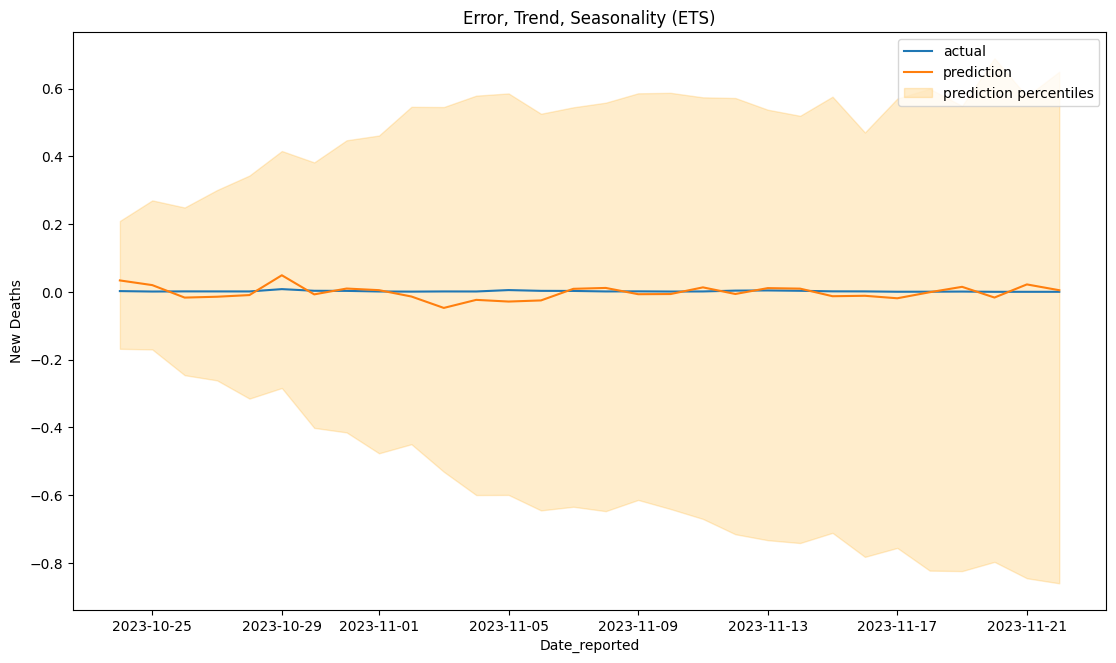

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 0.00
RMSE: 0.02
MAE: 0.02
MAPE: inf
SMAPE: 179.03


In [ ]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [ ]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["New_cases"],
        regressor_sign=["="],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status


































































































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































































































































































































































































chain 1 |██████████| 01:17 Sampling completed                     
chain 2 |██████████| 01:17 Sampling completed                     
chain 3 |██████████| 01:17 Sampling completed                     
chain 4 |██████████| 01:17 Sampling completed                     











































































































chain 1 |███████▌  | 01:21 Iteration: 100 / 250 [ 40%]  (Warmup)

























































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     






















































































































































































chain 1 |██████████| 01:49 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:47 Sampling completed                     
chain 2 |██████████| 00:47 Sampling completed                     
chain 3 |██████████| 00:47 Sampling completed                     
chain 4 |██████████| 00:47 Sampling completed                     























































































































































































chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     
































































chain 1 |          | 02:21 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     















chain 1 |██████████| 00:55 Sampling completed                     
chain 2 |██████████| 00:55 Sampling completed                     
chain 3 |██████████| 00:55 Sampling completed                     
chain 4 |██████████| 00:55 Sampling completed                     

chain 1 |          | 00:00 Status


















































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































































chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     



































































































































































chain 1 |██████████| 01:02 Sampling completed                     
chain 2 |██████████| 01:02 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     




















































































































































































chain 1 |██████████| 00:51 Sampling completed                     
chain 2 |██████████| 00:51 Sampling completed                     
chain 3 |██████████| 00:51 Sampling completed                     
chain 4 |██████████| 00:51 Sampling completed                     







































































chain 1 |███████▌  | 00:55 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































































chain 1 |██████████| 01:29 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |██████████| 01:26 Sampling completed                     
chain 2 |██████████| 01:26 Sampling completed                     
chain 3 |██████████| 01:26 Sampling completed                     
chain 4 |██████████| 01:26 Sampling completed                     


























































chain 1 |██████████| 01:07 Sampling completed                     
chain 2 |██████████| 01:07 Sampling completed                     
chain 3 |██████████| 01:07 Sampling completed                     
chain 4 |██████████| 01:07 Sampling completed                     


































































































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     















































chain 1 |          | 00:00 Status















































































































































































chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     
























































































































































































chain 1 |██████████| 01:03 Sampling completed                     
chain 2 |██████████| 01:03 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     

chain 1 |          | 00:00 Status









chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 01:13 Sampling completed                     
chain 2 |██████████| 01:13 Sampling completed                     
chain 3 |██████████| 01:13 Sampling completed                     
chain 4 |██████████| 01:13 Sampling completed                     










































chain 1 |██████████| 01:10 Sampling completed                     
chain 2 |██████████| 01:10 Sampling completed                     
chain 3 |██████████| 01:10 Sampling completed                     
chain 4 |██████████| 01:10 Sampling completed                     






chain 1 |███████▌  | 00:43 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     






























































chain 1 |██████████| 01:08 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

chain 1 |          | 00:00 Status














chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |███████▌  | 00:23 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 01:03 Sampling completed                     
chain 2 |██████████| 01:03 Sampling completed                     
chain 3 |██████████| 01:03 Sampling completed                     
chain 4 |██████████| 01:03 Sampling completed                     

chain 1 |██████████| 01:08 Sampling completed                     
chain 2 |██████████| 01:08 Sampling completed                     
chain 3 |██████████| 01:08 Sampling completed                     
chain 4 |██████████| 01:08 Sampling completed                     

In [ ]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_scores

{'{"global_trend_option": "flat"}': 32.97852534737982,
 '{"global_trend_option": "linear"}': 27.76912713702148,
 '{"global_trend_option": "loglinear"}': 42.6064934491118,
 '{"global_trend_option": "logistic"}': 64.16225768548786}

In [ ]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    regressor_sign=["="],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)
p = dlt.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

chain 1 |          | 00:00 Status










chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:59 Sampling completed                     
chain 2 |██████████| 00:59 Sampling completed                     
chain 3 |██████████| 00:59 Sampling completed                     
chain 4 |██████████| 00:59 Sampling completed                     

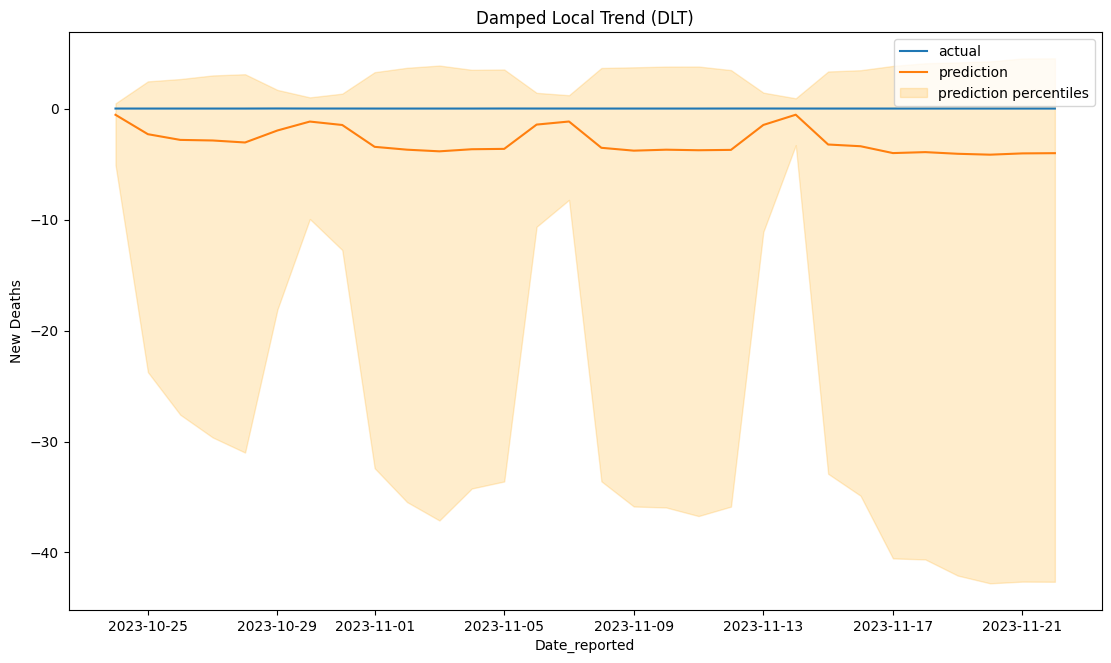

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 10.01
RMSE: 3.16
MAE: 2.95
MAPE: inf
SMAPE: 200.00


In [ ]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    seasonality=[90, 180, 360],
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases"],
    seed=2,
    verbose=False,
)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, "New_cases"]])
p = p.merge(valid, on=date_column, how="left")

2023-12-09 12:03:28 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


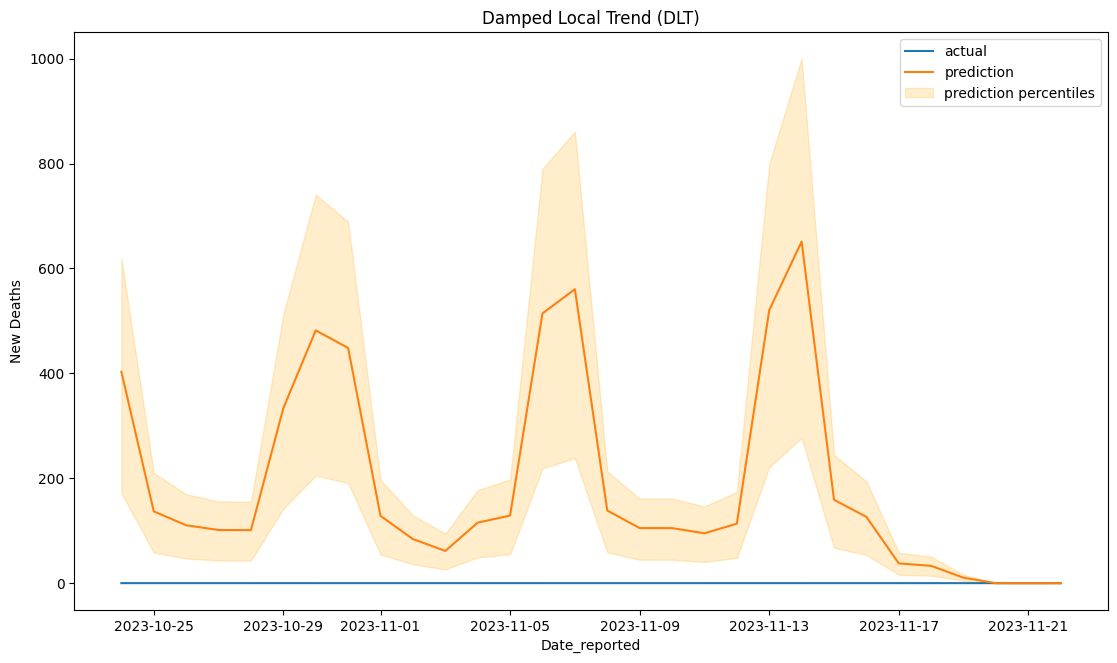

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.fill_between(
    p[date_column],
    p["prediction_5"],
    p["prediction_95"],
    alpha=0.2,
    color="orange",
    label="prediction percentiles",
)
ax.set_title("Damped Local Trend (DLT)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 73191.76
RMSE: 270.54
MAE: 193.46
MAPE: inf
SMAPE: 200.00
